In [ ]:
# import required packages
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow import keras
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import Compose, ToTensor, transforms, Normalize
from torch import nn, optim
from sklearn.model_selection import train_test_split

## Data Preprocessing

In [ ]:
# read the dataset
dftrain = pd.read_csv("train.csv")
dftest = pd.read_csv("test.csv")
submission_keras = pd.read_csv("sample_submission.csv")
submission_pytorch = pd.read_csv("sample_submission.csv")

In [ ]:
# split train and test data into input and output values
in_train = dftrain.loc[:, dftrain.columns!= "label"].values
out_train = dftrain["label"].values
in_test = dftest.values
in_train.shape, out_train.shape, in_test.shape

((17784, 784), (17784,), (18956, 784))

In [ ]:
# reshape data in 2 dimensions (height and width)
in_train = in_train.reshape(-1, 28, 28) 
in_test = in_test.reshape(-1, 28, 28)

## Exploratory Data Analysis



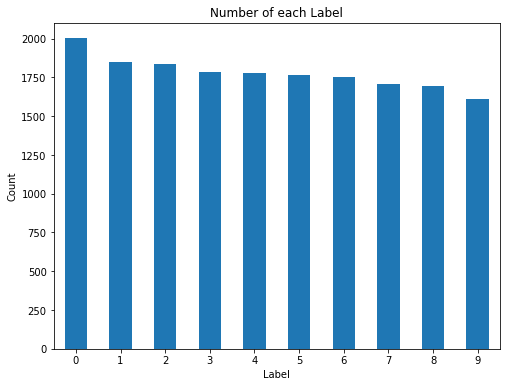

In [ ]:
# Distribution of digits in training data
ax = dftrain["label"].value_counts().plot(kind='bar', figsize=(8,6), title="Number of each Label")
ax.set_xlabel("Label")
ax.set_ylabel("Count")

# set x ticks
nums = [0, 1, 2,3,4,5,6,7,8,9]
ax.set_xticklabels(nums, rotation=0)
plt.show()

How many rows of training images would you like to review? 3


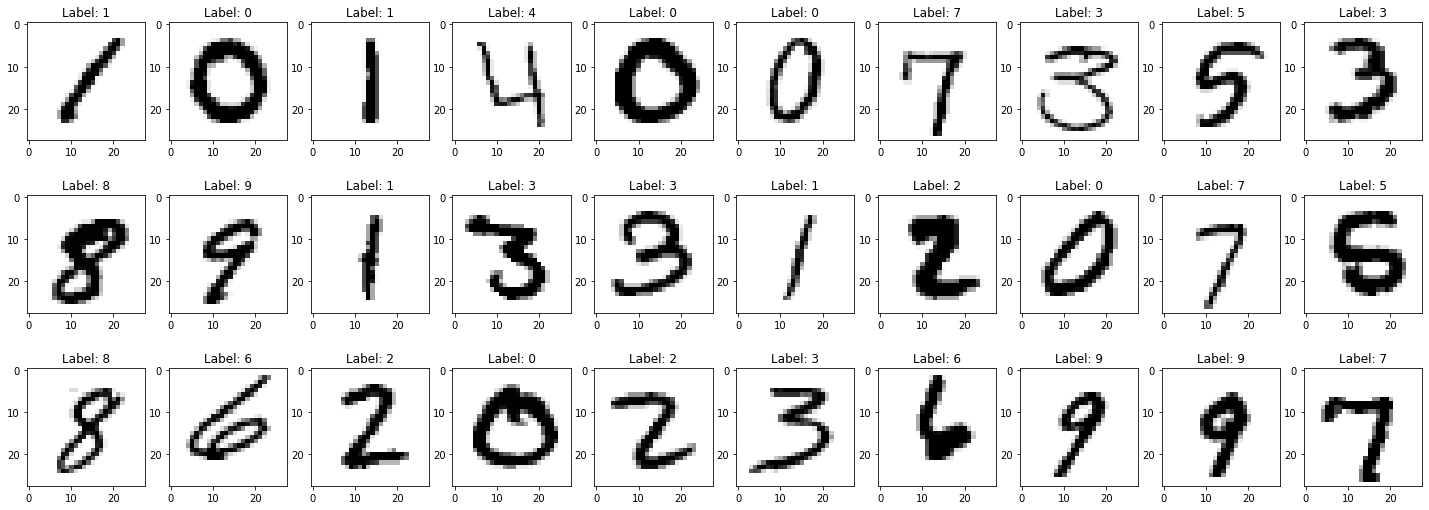

In [ ]:
# Prompt the user "How many rows of training images would you like to review?"
rows = int(input("How many rows of training images would you like to review? "))

fig, axes = plt.subplots(rows, 10, figsize=(25, rows * 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(in_train[i], cmap='binary')
    digit = out_train[i]
    ax.set(title = f'Label: {digit}')

## Keras model

In [ ]:
random.seed(5)
model = keras.Sequential(layers=[
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(200, activation="relu"), #increased dense layer relu size 
    keras.layers.Dense(45, activation="softmax")#increased dense layer softmax size 
])
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
#changed batch and epochs to 80
model.fit(in_train, out_train, batch_size=80, epochs=80, validation_split=0.2)

Epoch 1/80
420/420 [==============================] - 4s 9ms/step - loss: 5.8893 - accuracy: 0.8705 - val_loss: 2.0754 - val_accuracy: 0.9101
Epoch 2/80
420/420 [==============================] - 3s 7ms/step - loss: 1.2811 - accuracy: 0.9336 - val_loss: 1.2641 - val_accuracy: 0.9325
Epoch 3/80
420/420 [==============================] - 3s 6ms/step - loss: 0.6564 - accuracy: 0.9517 - val_loss: 0.9272 - val_accuracy: 0.9407
Epoch 4/80
420/420 [==============================] - 3s 8ms/step - loss: 0.3950 - accuracy: 0.9614 - val_loss: 0.7587 - val_accuracy: 0.9452
Epoch 5/80
420/420 [==============================] - 3s 8ms/step - loss: 0.2713 - accuracy: 0.9674 - val_loss: 0.7307 - val_accuracy: 0.9495
Epoch 6/80
420/420 [==============================] - 3s 7ms/step - loss: 0.2412 - accuracy: 0.9707 - val_loss: 0.6369 - val_accuracy: 0.9552
Epoch 7/80
420/420 [==============================] - 3s 7ms/step - loss: 0.2182 - accuracy: 0.9735 - val_loss: 0.6900 - val_accuracy: 0.9515
Epoch 

In [ ]:
# predict the test set
preds = model.predict(in_test).argsort()[:,-1]
print(preds)

[2 0 9 ... 3 9 2]


In [ ]:
# put prediction in submission file
for i in range(len(preds)):
  submission_keras['Label'][i] = preds[i]

# save as csv file to sumbit
submission_keras.to_csv("submission_keras.csv", index=False)

## Visualizing test result

How many rows of testing images would you like to review? 1


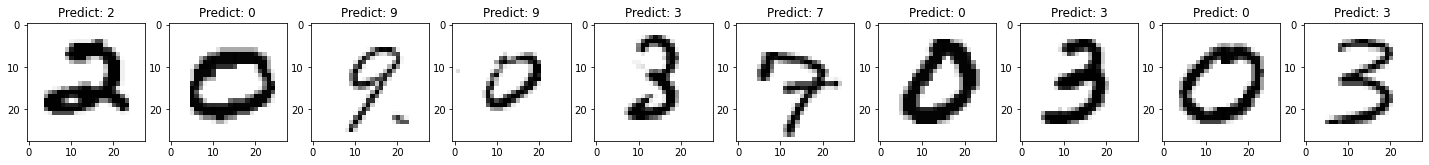

In [ ]:
# Prompt the user "How many rows of testing images would you like to review?"
rows = int(input("How many rows of testing images would you like to review? "))

fig, axes = plt.subplots(rows, 10, figsize=(25, rows * 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(in_test[i], cmap='binary')
    digit = preds[i]
    ax.set(title = f'Predict: {digit}')

## PyTorch model

In [ ]:
# Split data into training and validation part
# used https://pytorch.org/docs/stable/data.html for PyTorch model code
in_train, in_valid, out_train, out_valid = train_test_split(in_train, out_train, test_size=0.2)

In [ ]:
# Normalize data
in_train_tensor = torch.tensor(in_train) / 255.0
out_train_tensor = torch.tensor(out_train)
train_tensor = TensorDataset(in_train_tensor, out_train_tensor)

in_valid_tensor = torch.tensor(in_valid) / 255.0
out_valid_tensor = torch.tensor(out_valid)
val_tensor = TensorDataset(in_valid_tensor, out_valid_tensor)

test_tensor = torch.tensor(in_test) / 255.0

In [ ]:
# set batch size to 20
batch = 20
torch.manual_seed(20742)
load_train = DataLoader(train_tensor, batch_size=batch, shuffle=False)
torch.manual_seed(20742)
load_valid = DataLoader(val_tensor, batch_size=batch, shuffle=False)
load_test = DataLoader(test_tensor, batch_size=batch, shuffle=False)

In [ ]:
# create a sequential model of one hidden layer
input_size = 28 * 28
hidden_size = 500
output_size = 10
model = nn.Sequential(
  nn.Linear(input_size, hidden_size), 
  nn.Sigmoid(), 
  nn.Linear(hidden_size, output_size), 
  nn.Softmax(dim=1)) 
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=500, out_features=10, bias=True)
  (3): Softmax(dim=1)
)


In [ ]:
# train the model
torch.manual_seed(20742)
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # implement Adam algorithm with learning rate
error = nn.CrossEntropyLoss() # this criterion computes the cross entropy loss between input and target
epochs = 50
for epoch in range(epochs):
  running_loss = 0
  for images, labels in load_train:
    train = images.view(images.shape[0], -1) # flatten image into a 784 vector
    outputs = model(train)
    loss = error(outputs, labels)
    optimizer.zero_grad() # training pass
    loss.backward() # learn by backpropagation
    optimizer.step() # optimize weights
    running_loss += loss.item()
  else:
    total = 0
    correct = 0
    for images, labels in load_train:
      train = images.view(images.shape[0], -1) # flatten image into a 784 vector
      outputs = model(train)
      predictions = torch.max(outputs, 1)[1]
      correct += (predictions == labels).sum()
      total += len(labels)
    print(f'Epoch {epoch + 1}/{epochs} - loss: {running_loss / total} - accuracy: {correct / total}')

Epoch 1/50 - loss: 0.0732536066926661 - accuracy: 0.9959523677825928
Epoch 2/50 - loss: 0.07325033903121948 - accuracy: 0.9963392615318298
Epoch 3/50 - loss: 0.07324658284939471 - accuracy: 0.996279776096344
Epoch 4/50 - loss: 0.07324581178526084 - accuracy: 0.9963392615318298
Epoch 5/50 - loss: 0.07323961196555978 - accuracy: 0.9963690638542175
Epoch 6/50 - loss: 0.07323942317849114 - accuracy: 0.9955357313156128
Epoch 7/50 - loss: 0.07326233484915325 - accuracy: 0.9958630800247192
Epoch 8/50 - loss: 0.07324520374337833 - accuracy: 0.9964285492897034
Epoch 9/50 - loss: 0.07323622739031202 - accuracy: 0.9964285492897034
Epoch 10/50 - loss: 0.07325375869870186 - accuracy: 0.9963690638542175
Epoch 11/50 - loss: 0.07324444615060374 - accuracy: 0.9964583516120911
Epoch 12/50 - loss: 0.07323738075083211 - accuracy: 0.9963988065719604
Epoch 13/50 - loss: 0.07324814783320541 - accuracy: 0.9964583516120911
Epoch 14/50 - loss: 0.07323296699495542 - accuracy: 0.9965178370475769
Epoch 15/50 - los

In [ ]:
# calculate the accuracy for validation data set
count = 0
correct = 0
for images, labels in load_valid:
  test = images.view(images.shape[0], -1) # flatten image into a 784 vector
  with torch.no_grad():
    probs = model(test)
    preds = torch.max(probs, 1)[1]
  correct += (preds == labels).sum()
  count += len(labels)
print(f'Tested {count} images - accuracy: {correct / count}')

Tested 8400 images - accuracy: 0.9753571152687073


## Prediction on test data

In [ ]:
# create an empty list to record the prediction label
label = []
for images in load_test:
  test = images.view(images.shape[0], -1) # flatten image into a 784 vector
  with torch.no_grad():
    probs = model(test)
    preds = torch.max(probs, 1)[1]
  label.append(preds)

In [ ]:
# Create an empty list to make an one dimension model
flat_label = []

for i in label:
    # appending elements to the flat_label
    flat_label += i

# printing the resultantn flat_list
print(flat_label)

[tensor(2), tensor(0), tensor(9), tensor(9), tensor(3), tensor(7), tensor(0), tensor(3), tensor(0), tensor(3), tensor(5), tensor(7), tensor(4), tensor(0), tensor(4), tensor(5), tensor(3), tensor(1), tensor(9), tensor(0), tensor(9), tensor(1), tensor(1), tensor(5), tensor(7), tensor(4), tensor(2), tensor(7), tensor(7), tensor(7), tensor(7), tensor(5), tensor(4), tensor(2), tensor(6), tensor(2), tensor(5), tensor(5), tensor(1), tensor(6), tensor(7), tensor(7), tensor(4), tensor(9), tensor(8), tensor(7), tensor(8), tensor(2), tensor(6), tensor(7), tensor(6), tensor(8), tensor(8), tensor(3), tensor(8), tensor(2), tensor(1), tensor(2), tensor(2), tensor(0), tensor(4), tensor(1), tensor(7), tensor(0), tensor(0), tensor(0), tensor(1), tensor(9), tensor(0), tensor(1), tensor(6), tensor(5), tensor(8), tensor(8), tensor(2), tensor(8), tensor(9), tensor(9), tensor(2), tensor(3), tensor(5), tensor(9), tensor(1), tensor(0), tensor(9), tensor(2), tensor(4), tensor(3), tensor(6), tensor(7), tensor(2)

In [ ]:
# put prediction in submission file
for i in range(len(flat_label)):
  submission_pytorch['Label'][i] = flat_label[i]

# save as csv file to sumbit
submission_pytorch.to_csv("submission_pytorch.csv", index=False)